*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

     |████████████████████████████████| 499.2 MB 13 kB/s 
     |████████████████████████████████| 5.8 MB 33.9 MB/s 
     |████████████████████████████████| 1.6 MB 20.3 MB/s 
     |████████████████████████████████| 438 kB 46.3 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, but you have tf-estimator-nightly 2.9.0.dev2022030109 which is incompatible.
2.9.0-dev20220301


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-03-01 21:02:15--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.01s   

2022-03-01 21:02:15 (32.7 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2022-03-01 21:02:15--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

Loading data into pandas DataFrames

In [ ]:
train_df = pd.read_csv(train_file_path, names = ['type', 'message'], sep='\t')
test_df = pd.read_csv(test_file_path, names = ['type', 'message'], sep='\t')

In [ ]:
train_df.head()

,type,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [ ]:
test_df.tail()

,type,message
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...
1391,spam,not heard from u4 a while. call 4 rude chat pr...


Converting type to categorical value

In [ ]:
test_df['type'] = pd.Categorical(test_df['type'])
test_df['type'] = test_df.type.cat.codes

In [ ]:
test_df.tail()

,type,message
1387,0,true dear..i sat to pray evening and felt so.s...
1388,0,"what will we do in the shower, baby?"
1389,0,where are you ? what are you doing ? are yuou ...
1390,1,ur cash-balance is currently 500 pounds - to m...
1391,1,not heard from u4 a while. call 4 rude chat pr...


In [ ]:
train_df['type'] = pd.Categorical(train_df['type'])
train_df['type'] = train_df.type.cat.codes

In [ ]:
train_df.head()

,type,message
0,0,ahhhh...just woken up!had a bad dream about u ...
1,0,you can never do nothing
2,0,"now u sound like manky scouse boy steve,like! ..."
3,0,mum say we wan to go then go... then she can s...
4,0,never y lei... i v lazy... got wat? dat day ü ...


Load data using tf.data.Dataset

In [ ]:
y_train, y_test = train_df.pop('type'), test_df.pop('type')
train_dataset = tf.data.Dataset.from_tensor_slices((train_df.values, y_train.values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df.values, y_test.values))

Converting sentences into embeddings vectors and using a pre-trained text embedding

In [ ]:
import tensorflow_hub as hub

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_df.message.values[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.32541978, -0.3133123 , -0.5480365 ,  0.24598306,  0.20648922,
        -0.19692461,  0.14695725, -0.22615463, -0.37861764,  0.37530652,
         0.09431016,  0.14134113,  0.02833728, -0.00874456, -0.31407544,
         0.1386168 ,  0.08098313,  0.36827627,  0.18604349, -0.2482912 ,
        -0.00867229,  0.01006516,  0.38594577,  0.10873004, -0.23007846,
        -0.00972341, -0.78613126, -0.10259399, -0.06492783,  0.0398381 ,
        -0.440943  ,  0.13856299,  0.2843286 ,  0.05254516, -0.2947216 ,
        -0.00208754,  0.38934538, -0.24034083,  0.08555654, -0.11941122,
         0.48032042,  0.4848208 , -0.09254314, -0.35031077, -0.25826845,
         0.30084088, -0.33162662, -0.05877384,  0.3220848 ,  0.2209478 ],
       [ 0.1299392 , -0.13448243, -0.1288807 ,  0.24374685,  0.05074961,
         0.04791179,  0.07844765,  0.03094704, -0.38060176,  0.5000811 ,
        -0.02153497,  0.1905233 , -0.07349987,  0.04944809, -0.20843968,
 

Let's now build the full model:

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_4 (Dense)             (None, 16)                816       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


Loss function and optimizer

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model

In [ ]:
history = model.fit(train_dataset.shuffle(10000).batch(512),
                    epochs=20,
                    verbose=1)

Epoch 1/20
9/9 [==============================] - 1s 58ms/step - loss: 0.6991 - accuracy: 0.8626
Epoch 2/20
9/9 [==============================] - 0s 53ms/step - loss: 0.6104 - accuracy: 0.8660
Epoch 3/20
9/9 [==============================] - 0s 52ms/step - loss: 0.5422 - accuracy: 0.8665
Epoch 4/20
9/9 [==============================] - 0s 51ms/step - loss: 0.4792 - accuracy: 0.8665
Epoch 5/20
9/9 [==============================] - 0s 53ms/step - loss: 0.4167 - accuracy: 0.8686
Epoch 6/20
9/9 [==============================] - 0s 52ms/step - loss: 0.3577 - accuracy: 0.8763
Epoch 7/20
9/9 [==============================] - 0s 49ms/step - loss: 0.3043 - accuracy: 0.8873
Epoch 8/20
9/9 [==============================] - 0s 53ms/step - loss: 0.2580 - accuracy: 0.9100
Epoch 9/20
9/9 [==============================] - 0s 51ms/step - loss: 0.2174 - accuracy: 0.9318
Epoch 10/20
9/9 [==============================] - 0s 53ms/step - loss: 0.1826 - accuracy: 0.9505
Epoch 11/20
9/9 [============

Evaluating the model

In [ ]:
results = model.evaluate(test_dataset.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

3/3 - 0s - loss: 0.0757 - accuracy: 0.9828 - 400ms/epoch - 133ms/step
loss: 0.076
accuracy: 0.983


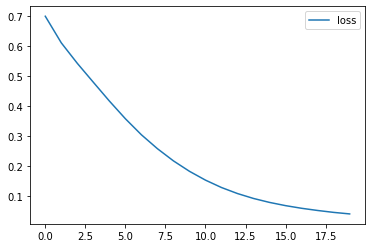

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.legend()

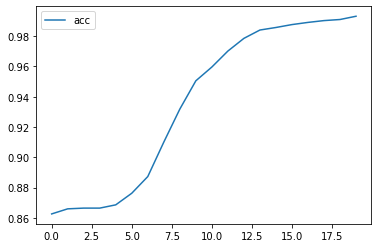

In [ ]:
plt.plot(history.history['accuracy'], label='acc')
plt.legend()

Challenge

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  prediction = model.predict(pd.Series(pred_text), verbose=0)

  return (prediction[0], "ham" if prediction < 0.0 else "spam")

pred_text = "buy a new coke now!"

prediction = predict_message(pred_text)
print(prediction)

(array([1.5727373], dtype=float32), 'spam')


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
